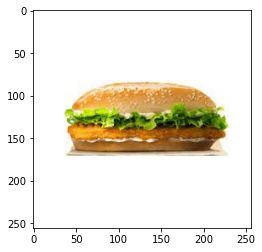

In [1]:
!pip install opencv-python
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

imageFile = 'burgao2.jpg'
img = np.array(Image.open(imageFile))[:, :, :3]
(l, c ,p) = img.shape
plt.imshow(img)

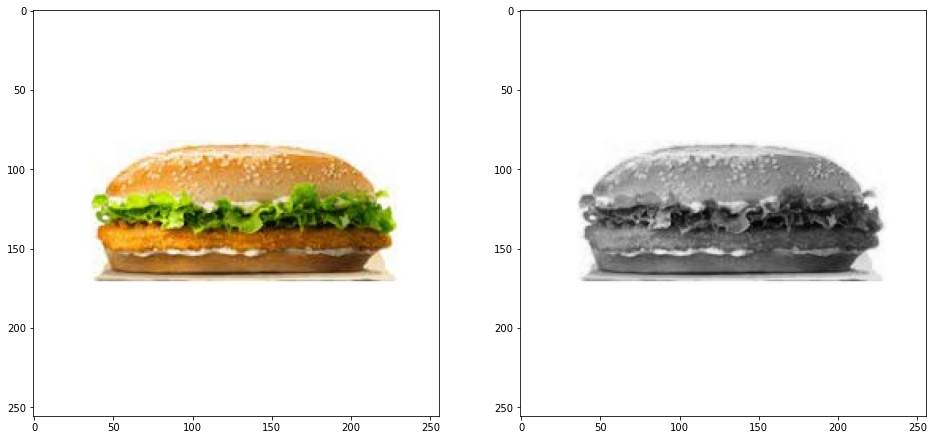

In [2]:
# converter para escala de cinza:
imgGray = np.zeros(shape=(l, c), dtype=np.uint8)
for i in range(l):
    for j in range(c):
        r = float(img[i, j, 0])
        g = float(img[i, j, 1])
        b = float(img[i, j, 2])
        
        imgGray[i, j] = (r + g + b) / 3

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(imgGray, cmap='gray')

In [3]:
ni = np.array(imgGray)
height ,width = ni.shape[:2]
print(f'Height: {height}, width: {width}')


Height: 256, width: 256


In [4]:
#dividing 8x8 parts
block = 8
sliced = [] # new list for 8x8 sliced image 
currY = 0 #current Y index
for i in range(block,height+1,block):
    currX = 0 #current X index
    for j in range(block,width+1,block):
        sliced.append(imgGray[currY:i,currX:j]-np.ones((8,8))*128) #Extracting 128 from all pixels
        currX = j
    currY = i
    
print("Size of the sliced image: "+str(len(sliced)))
print("Each elemend of sliced list contains a "+ str(sliced[0].shape)+ " element.")

Size of the sliced image: 1024
Each elemend of sliced list contains a (8, 8) element.


In [5]:
imf = [np.float32(img) for img in sliced]

In [6]:
import cv2

DCToutput = [] # Transformação e quantização discreta de Cosseno
for part in imf:
    currDCT = cv2.dct(part)
    DCToutput.append(currDCT)
DCToutput[0][0]

array([1016.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
      dtype=float32)

In [7]:
#Quantization Arrays

def selectQMatrix(qName):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])

    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if qName == "Q10":
        return Q10
    elif qName == "Q50":
        return Q50
    elif qName == "Q90":
        return Q90
    else:
        return np.ones((8,8)) #it suppose to return original image back

In [8]:
selectedQMatrix = selectQMatrix("Q10")
for ndct in DCToutput:
    for i in range(block):
        for j in range(block):
            ndct[i,j] = np.around(ndct[i,j]/selectedQMatrix[i,j])
DCToutput[0][0]

array([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [9]:
invList = []
for ipart in DCToutput:
    ipart
    curriDCT = cv2.idct(ipart)
    invList.append(curriDCT)
invList[0][0]

array([1.625, 1.625, 1.625, 1.625, 1.625, 1.625, 1.625, 1.625],
      dtype=float32)

In [10]:
row = 0
rowNcol = []
for j in range(int(width/block),len(invList)+1,int(width/block)):
    rowNcol.append(np.hstack((invList[row:j])))
    row = j
res = np.vstack((rowNcol))

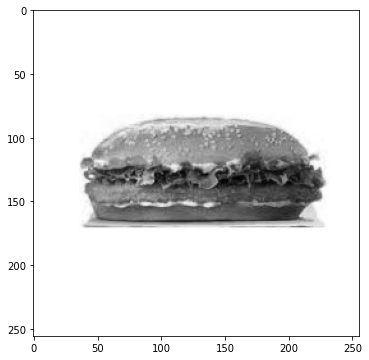

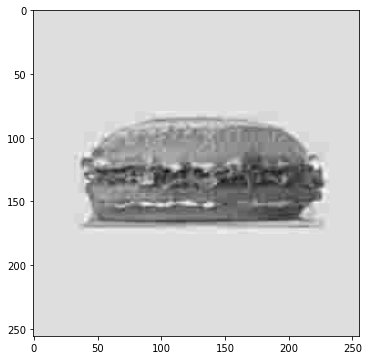

In [14]:
plt.figure(figsize=(6, 6))
#plt.subplot(1, 2, 1)
plt.imshow(imgGray, cmap='gray')
plt.figure(figsize=(6, 6))
#plt.subplot(1, 2, 2)
plt.imshow(res, cmap='gray')